In [8]:
from __future__ import annotations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sbn
from typing import Any, List, Type
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
from datetime import datetime
from sklearn.metrics import mean_squared_error
import time
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
import plotly.express as px
from SpatialScan.timeseries import *
from scipy.optimize import minimize

In [9]:
import tensorflow as tf
from tensorflow import keras

In [10]:
df = pd.read_csv('ActonAprilJune.csv', index_col=False, infer_datetime_format=True, parse_dates=[4, 5])
detector_sample=df["detector_id"].drop_duplicates().sample(4).to_numpy()
detector_sample=np.append(detector_sample, ["N27/011c1"])
df_list=[]
for i in detector_sample:
    df_list.append(df[df["detector_id"] == i])

df2 = pd.concat(df_list)

In [11]:
DF=interpolator(df2, percentage_missing=30)

C:\Users\t_tho\SpatialScan\SpatialScan\timeseries.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["hour"] = dataset["measurement_start_utc"].dt.hour.to_numpy()
C:\Users\t_tho\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


detectors dropped:  []tectors


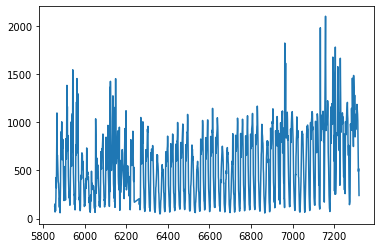

In [12]:
plt.plot(DF[DF["detector_id"]=="N27/011c1"]["n_vehicles_in_interval"])

In [15]:
detector_sample=df["detector_id"].drop_duplicates().sample(10).to_numpy()

In [6]:
df_d=df[df["detector_id"]==detector_sample[0]]

In [8]:
detector_sample

array(['N11/167a1'], dtype=object)

In [16]:
detector_sample=np.append(detector_sample, df["detector_id"].drop_duplicates().sample(10).to_numpy())
detector_sample=np.append(detector_sample, ["N21/158c1"])

In [17]:
detector_sample=np.append(detector_sample, df["detector_id"].drop_duplicates().sample(10).to_numpy())

In [12]:
start_time = time.time()
Y =count_baseline(df, 15, 1, method="HW", detectors=detector_sample)
print(time.time()-start_time)

1.1182746887207031


In [26]:
HW_opt([0.1, 0.1, 0.1], df, ['N12/125x1'])

4345.500115549657

In [16]:
mean_squared_error(Y.dropna()["count"], Y.dropna()["baseline"])

3698.08289195336

In [7]:
def HW_opt(params, df, detector):
    alpha=params[0]
    beta=params[1]
    gamma=params[2]
    Y = count_baseline(df, 15, 2, method="HW", detectors=detector, alpha=alpha, beta=beta, gamma=gamma)
    return(mean_squared_error(Y.dropna()["count"], Y.dropna()["baseline"]))

In [29]:
HW_opt([0.01304203, 0.47790069, 0.10299988], df, ['N12/125x1'])

2623.3852315287595

In [8]:
a=0.1
b=0.1
c=0.1

res = minimize(HW_opt, [a, b, c], args=(df_d, ['N01/236g1']), method="Powell", options= {'ftol': 1000})
print(res)

C:\Users\t_tho\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:254: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,


   direc: array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])
     fun: 698.0343285554451
 message: 'Optimization terminated successfully.'
    nfev: 47
     nit: 1
  status: 0
 success: True
       x: array([0.04760954, 0.15154148, 0.28410787])


In [9]:
Y = count_baseline(df, 15, 2, method="HW", detectors=['N11/167a1'], alpha=0.04760954, beta=0.15154148, gamma=0.28410787)

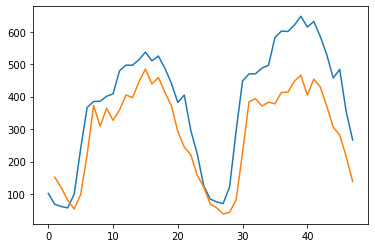

In [10]:
plt.plot(Y["baseline"])
plt.plot(Y["count"])

In [69]:
def interpolator(df):
    detectors = df["detector_id"].drop_duplicates().to_numpy()
    df_list=[]
    i=0
    for detector in detectors:
        dataset=df[df["detector_id"]==detector]
        dataset.index=dataset["measurement_end_utc"]
        
        T=pd.date_range(start=df["measurement_end_utc"].min(), end=df["measurement_end_utc"].max(), freq='H')
        dataset = dataset.reindex(T)
        num_nan=dataset["n_vehicles_in_interval"].isna().sum()
        if(num_nan>int(len(dataset)/6)):
            print(detector)
            continue

        dataset["n_vehicles_in_interval"]=dataset["n_vehicles_in_interval"].interpolate(method='linear', limit_direction='forward', axis=0)
        dataset["detector_id"]=dataset["detector_id"].interpolate(method='pad', limit_direction='forward', axis=0)
        dataset["lon"]=dataset["lon"].interpolate(method='pad', limit_direction='forward', axis=0)
        dataset["lat"]=dataset["lat"].interpolate(method='pad', limit_direction='forward', axis=0)
        dataset["measurement_end_utc"]=dataset.index
        dataset["measurement_start_utc"]=dataset["measurement_end_utc"]-+ np.timedelta64(1, "h")

        df_list.append(dataset)
        i+=1
        print("please wait: ", i, "/", len(detectors), end="\r")
    DF = pd.concat(df_list)
    
    return DF.reset_index(drop=True)

In [6]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, RBF, Matern

In [198]:
kernel = RBF(length_scale=2*24)*(ExpSineSquared(length_scale=1, periodicity=24.0)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

In [199]:
X_train=np.arange(0, len(df_d)-72).reshape(-1, 1)
X_test=np.arange(len(df_d)-72, len(df_d)).reshape(-1, 1)
y_train=df_d["n_vehicles_in_interval"][0:len(df_d)-72].to_numpy().reshape(-1, 1)
y_test=df_d["n_vehicles_in_interval"][len(df_d)-72:len(df_d)].to_numpy().reshape(-1, 1)
gp2 = GaussianProcessRegressor(kernel=kernel,
                              alpha=0.0).fit(X_train, y_train)

In [200]:
y_mean, y_cov=gp2.predict(X_train, return_cov=True)

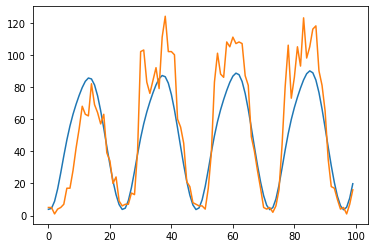

In [201]:
plt.plot(y_mean.flatten()[0:100])
plt.plot(y_train[0:100])

In [168]:
y_mean, y_cov=gp2.predict(X_test, return_cov=True)

In [7]:
df_d["hour"]=df_d["measurement_start_utc"].dt.hour.to_numpy()

C:\Users\t_tho\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [8]:
threshold=(df_d.groupby("hour").mean()["n_vehicles_in_interval"]-3*df_d.groupby("hour").std()["n_vehicles_in_interval"])

In [9]:
df_d

,Unnamed: 0,detector_id,lon,lat,measurement_start_utc,measurement_end_utc,n_vehicles_in_interval,hour
1408,4794,N12/008d1,-0.190833,51.494775,2020-04-05 00:00:00,2020-04-05 01:00:00,36,0
4169,14540,N12/008d1,-0.190833,51.494775,2020-04-05 01:00:00,2020-04-05 02:00:00,34,1
6851,24137,N12/008d1,-0.190833,51.494775,2020-04-05 02:00:00,2020-04-05 03:00:00,25,2
9469,33718,N12/008d1,-0.190833,51.494775,2020-04-05 03:00:00,2020-04-05 04:00:00,30,3
12694,44013,N12/008d1,-0.190833,51.494775,2020-04-05 04:00:00,2020-04-05 05:00:00,58,4
...,...,...,...,...,...,...,...,...
4013922,14463379,N12/008d1,-0.190833,51.494775,2020-06-04 19:00:00,2020-06-04 20:00:00,341,19
4016702,14473405,N12/008d1,-0.190833,51.494775,2020-06-04 20:00:00,2020-06-04 21:00:00,264,20
4019839,14483817,N12/008d1,-0.190833,51.494775,2020-06-04 21:00:00,2020-06-04 22:00:00,215,21
4022185,14493113,N12/008d1,-0.190833,51.494775,2020-06-04 22:00:00,2020-06-04 23:00:00,149,22


In [12]:
for i in range(0, len(df_d)):
    if(df_d.iloc[i]["n_vehicles_in_interval"]>threshold[df_d.iloc[i]["hour"]]):
        df_d.iloc[0, df_d.columns.get_loc("n_vehicles_in_interval")]=float("NaN")

C:\Users\t_tho\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [10]:
df_d.iloc[0, df_d.columns.get_loc("n_vehicles_in_interval")] = 10000

C:\Users\t_tho\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [13]:
df_d

,Unnamed: 0,detector_id,lon,lat,measurement_start_utc,measurement_end_utc,n_vehicles_in_interval,hour
1408,4794,N12/008d1,-0.190833,51.494775,2020-04-05 00:00:00,2020-04-05 01:00:00,NaN,0
4169,14540,N12/008d1,-0.190833,51.494775,2020-04-05 01:00:00,2020-04-05 02:00:00,34.0,1
6851,24137,N12/008d1,-0.190833,51.494775,2020-04-05 02:00:00,2020-04-05 03:00:00,25.0,2
9469,33718,N12/008d1,-0.190833,51.494775,2020-04-05 03:00:00,2020-04-05 04:00:00,30.0,3
12694,44013,N12/008d1,-0.190833,51.494775,2020-04-05 04:00:00,2020-04-05 05:00:00,58.0,4
...,...,...,...,...,...,...,...,...
4013922,14463379,N12/008d1,-0.190833,51.494775,2020-06-04 19:00:00,2020-06-04 20:00:00,341.0,19
4016702,14473405,N12/008d1,-0.190833,51.494775,2020-06-04 20:00:00,2020-06-04 21:00:00,264.0,20
4019839,14483817,N12/008d1,-0.190833,51.494775,2020-06-04 21:00:00,2020-06-04 22:00:00,215.0,21
4022185,14493113,N12/008d1,-0.190833,51.494775,2020-06-04 22:00:00,2020-06-04 23:00:00,149.0,22


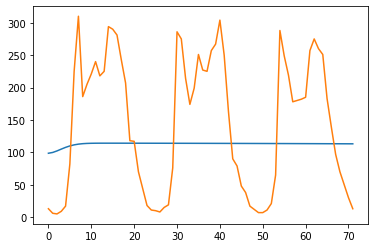

In [169]:
plt.plot(y_mean.flatten()[0:100])
plt.plot(y_test)

In [11]:
len(df_d["n_vehicles_in_interval"].to_numpy())

1460

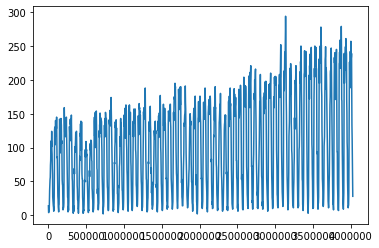

In [14]:
plt.plot(df_d["n_vehicles_in_interval"])

In [71]:
len(DF["detector_id"].drop_duplicates().to_numpy())

2672

In [ ]:
DF

N11/090r1


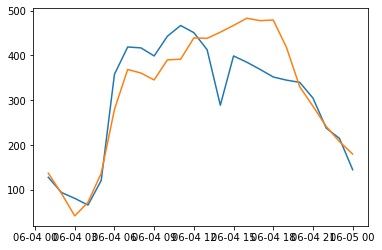

N14/224s2


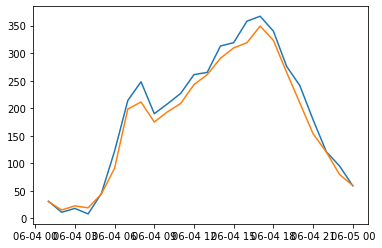

N07/028d1


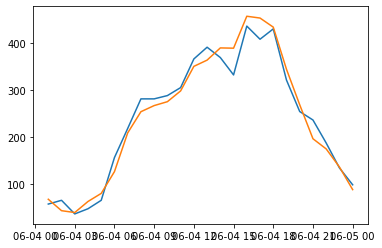

N05/207s1


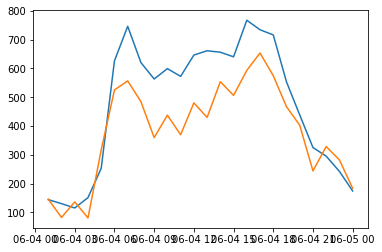

N24/162e1


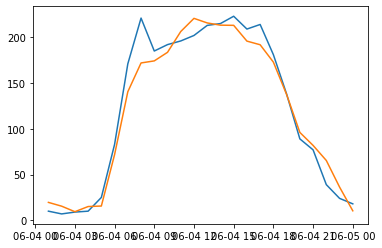

N15/007z1


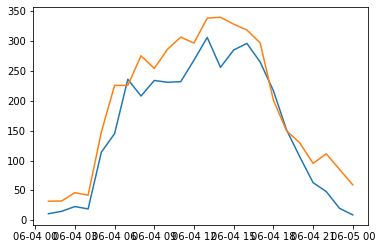

N04/103b1


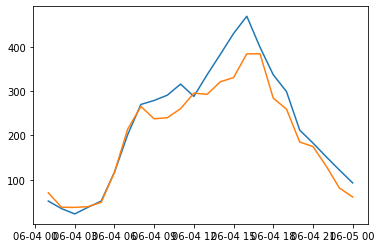

N12/119a1


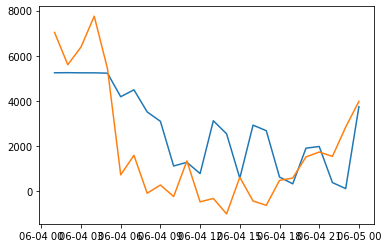

N09/034b2


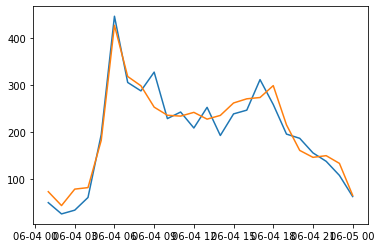

N20/013v1


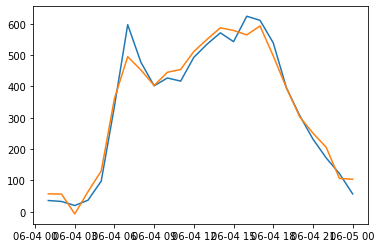

In [18]:
for detector in detector_sample:
    print(detector)
    plt.plot(Y[Y["detector_id"]==detector]["measurement_end_utc"], Y[Y["detector_id"]==detector]["count"])
    plt.plot(Y[Y["detector_id"]==detector]["measurement_end_utc"], Y[Y["detector_id"]==detector]["baseline"])
    plt.show()
        

In [9]:
Y

,detector_id,lon,lat,measurement_start_utc,measurement_end_utc,baseline,Unnamed: 0,count,C/B,hour_from_start
0,N27/129a1,-0.379131,51.542269,2020-06-04 00:00:00,2020-06-04 01:00:00,214.539764,14271147.0,140.0,0.652560,0.0
1,N27/129a1,-0.379131,51.542269,2020-06-04 01:00:00,2020-06-04 02:00:00,175.262329,14280316.0,116.0,0.661865,1.0
2,N27/129a1,-0.379131,51.542269,2020-06-04 02:00:00,2020-06-04 03:00:00,163.349808,14290710.0,97.0,0.593818,2.0
3,N27/129a1,-0.379131,51.542269,2020-06-04 03:00:00,2020-06-04 04:00:00,186.363617,14300132.0,109.0,0.584878,3.0
4,N27/129a1,-0.379131,51.542269,2020-06-04 04:00:00,2020-06-04 05:00:00,265.533966,14310581.0,253.0,0.952797,4.0
...,...,...,...,...,...,...,...,...,...,...
235,N22/001b1,-0.192481,51.417047,2020-06-04 19:00:00,2020-06-04 20:00:00,317.022827,14460968.0,323.0,1.018854,19.0
236,N22/001b1,-0.192481,51.417047,2020-06-04 20:00:00,2020-06-04 21:00:00,213.559891,14471267.0,232.0,1.086346,20.0
237,N22/001b1,-0.192481,51.417047,2020-06-04 21:00:00,2020-06-04 22:00:00,208.414612,14481046.0,201.0,0.964424,21.0
238,N22/001b1,-0.192481,51.417047,2020-06-04 22:00:00,2020-06-04 23:00:00,119.741592,14490888.0,117.0,0.977104,22.0


In [43]:
df[df["detector_id"]=="N21/018a1"][df[df["detector_id"]=="N21/018a1"]["measurement_end_utc"]<"2020-05-15 17:00:00"]

,Unnamed: 0,detector_id,lon,lat,measurement_start_utc,measurement_end_utc,n_vehicles_in_interval
995,2491,N21/018a1,-0.243979,51.380043,2020-04-05 00:00:00,2020-04-05 01:00:00,24
3754,12238,N21/018a1,-0.243979,51.380043,2020-04-05 01:00:00,2020-04-05 02:00:00,16
6456,22209,N21/018a1,-0.243979,51.380043,2020-04-05 02:00:00,2020-04-05 03:00:00,14
9177,31881,N21/018a1,-0.243979,51.380043,2020-04-05 03:00:00,2020-04-05 04:00:00,7
11712,41097,N21/018a1,-0.243979,51.380043,2020-04-05 04:00:00,2020-04-05 05:00:00,23
...,...,...,...,...,...,...,...
177971,639070,N21/018a1,-0.243979,51.380043,2020-04-07 18:00:00,2020-04-07 19:00:00,277
180720,648715,N21/018a1,-0.243979,51.380043,2020-04-07 19:00:00,2020-04-07 20:00:00,70
183128,658264,N21/018a1,-0.243979,51.380043,2020-04-07 20:00:00,2020-04-07 21:00:00,0
185075,665889,N21/018a1,-0.243979,51.380043,2020-04-07 21:00:00,2020-04-07 22:00:00,3
